# Loss function Rodrigues

$𝒟 = \{ \mathbf{x}_n, \mathbf{y}_n\}$ be a dataset of size $N$

$\mathbf{x}_n \in \mathbb{R}^D$

${\mathbf{y}}^r_n\in[0,1]^K$:   label provided for the r-th annotator in a set of R annotators

$𝒛_n$ Latent true class determined by a softmax output layer  of a DNN


$\mathbf{\sigma}\in \mathbb{R} ^Q$: DNN-based feature representation. correspond to the output of a softmax layer

$\hat{\mathbf{y}}^r_n = f_r(\sigma)\in[0,1]^{1 \times K}$

$\hat{\mathbf{y}}_n=[\hat{\mathbf{y}}^1_n,\hat{\mathbf{y}}^2_n,\dots,\hat{\mathbf{y}}^R_n]\in [0,1]^{1\times (R\times K)}$

Activation of the crowd layer for each anotator  $ \mathbf{a}^r = f_r(\sigma)$, where $f_r$ is an annotator-specific function, and the output of the crowd layer simply as the softmax of the
activations $o_c^r = e^{a_c^r}/\sum_{l=1}^{C}e^{a_l^r}$.


 $f_r(\sigma)= \mathbf{W}^r\mathbf{\sigma}$

 $\mathbf{W}^r$ is an annotator-specific matrix

 **Cost function**

 $E(\mathbf{o}^r, y^r)$
 between the expected output of the r-th annotator and its actual label $y^r$,

Then, 

if we make. $\lambda_n^r(\theta) = \mathbf{1}$ in PRI loss



$$\min_\theta \sum_n\left(\sum_r \lambda_n^r(\theta)H({\mathbf{y}}^r_n;\hat{\mathbf{y}}_n(\theta))\right)+\left(H(\hat{\mathbf{y}}_n(\theta))\sum_r\left(1-\lambda_n^r(\theta)\right)\right)$$

 
we can obtain rodriguez


$$\min_\theta \sum_n\left(\sum_r (\mathbf{1})H({\mathbf{y}}^r_n;\hat{\mathbf{y}}_n(\theta))\right)+\left(H(\hat{\mathbf{y}}_n(\theta))\sum_r\left(1-\mathbf{1}\right)\right)$$

In [1]:
#!pip install tensorflow==2.7.0
#!pip install scikeras 

In [2]:
#cargar datos desde drive acceso libre
FILEID = "1SQnWXGROG2Xexs5vn3twuv7SqiWG5njW"
#https://drive.google.com/file/d/1SQnWXGROG2Xexs5vn3twuv7SqiWG5njW/view?usp=sharing
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O MADatasets.zip && rm -rf /tmp/cookies.txt
!unzip -o MADatasets.zip
!dir

--2023-02-09 15:24:32--  https://docs.google.com/uc?export=download&confirm=t&id=1SQnWXGROG2Xexs5vn3twuv7SqiWG5njW
Resolving docs.google.com (docs.google.com)... 173.194.211.101, 173.194.211.102, 173.194.211.139, ...
Connecting to docs.google.com (docs.google.com)|173.194.211.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-90-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/8qmp9li7flc13npqi9oc2gpsa9k3ub7h/1675956225000/07591141114418430227/*/1SQnWXGROG2Xexs5vn3twuv7SqiWG5njW?e=download&uuid=81189d9b-7e16-4527-9112-2d0551ceb3ac [following]
--2023-02-09 15:24:32--  https://doc-00-90-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/8qmp9li7flc13npqi9oc2gpsa9k3ub7h/1675956225000/07591141114418430227/*/1SQnWXGROG2Xexs5vn3twuv7SqiWG5njW?e=download&uuid=81189d9b-7e16-4527-9112-2d0551ceb3ac
Resolving doc-00-90-docs.googleusercontent.com (doc-00-90-docs.googleusercontent.com)... 142.251.162.

# Subclassing for Crowdlayer Rodriguez

In [3]:

import tensorflow as tf
import numpy as np
from scipy.io import loadmat
from sklearn.preprocessing import StandardScaler
from scipy.io import savemat
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import mode 
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA

def ook(t):
  lb = LabelBinarizer()
  y_ook = lb.fit_transform(t)  

  if len(np.unique(t))==2:
    y_ook = np.concatenate((1-y_ook.astype(bool), y_ook), axis = 1) 

  return y_ook


def scheduler1(step = 10, ratio = 1.2):
  def scheduler(epoch, lr):
    if epoch % step == 0 and epoch>1:
      return lr/ratio
    else:
      return lr
  return scheduler

In [4]:
# -*- coding: utf-8 -*-
import tensorflow as tf
import matplotlib.pyplot as plt
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import tensorflow_probability as tfp
from tensorflow.keras import regularizers
from sklearn.base import  BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.model_selection import train_test_split
tf.keras.backend.clear_session()
#tf.random.set_seed(42)
import types
import tempfile
class Keras_MA_CrowdL(): #transformer no va
 #Constructor __init__. Special method: identified by a double underscore at either side of their name
 #work in the background
 # initialize data members to the object. lets the class initialize the object’s attributes and serves no other purpose.
    def __init__(self,epochs=70,batch_size=30,R=5, K=2, dropout=0.5, learning_rate=1e-3,optimizer='Adam', 
                  l1_param=0, validation_split=0.3, verbose=0):
        #print('init')
        self.epochs=epochs
        self.dropout=dropout
        self.batch_size = batch_size
        self.learning_rate=learning_rate 
        self.l1_param=l1_param 
        self.l2_param=l1_param
        self.validation_split = validation_split
        self.verbose = verbose
        self.optimizer = optimizer
        self.R=R
        self.K=K

        
    
    def custom_CLR_loss(self, y_true, y_pred):
        #tf.print(y_true.shape)
        #tf.print(y_pred.shape)
        vec = tf.nn.softmax_cross_entropy_with_logits(logits=y_pred, labels=y_true, axis = 1)
        mask = tf.equal(y_true[:,0,:], -1)
        zer = tf.zeros_like(vec)
        loss = tf.where(mask, x=zer, y=vec)
        return loss

#     def custom_CLR_loss(self, y_true, y_pred): #ytrue \in N x R,  ypred \in N x K x R  ->CrowdLayerRodriguez
#        # tf.print(tf.cast(y_true,dtype=tf.int32))
#         Y_true_1K = tf.one_hot(tf.cast(y_true,dtype=tf.int32),depth=self.K,axis=1) #samples, classes 1-K, annotators
#         #Y_true_1K = tf.one_hot(y_true,depth=self.K,axis=1) #samples, classes 1-K, annotators
          
        
#         #print(vec.shape)
#         mask = tf.equal(Y_true_1K[:,0,:], -1)
#         tf.print(Y_true_1K[:,0,:])
#         vec = tf.nn.softmax_cross_entropy_with_logits(logits=y_pred, labels=Y_true_1K, axis = 1)
#         zer = tf.zeros_like(vec)
#         loss = tf.where(mask, x=zer, y=vec)
#         #tf.print("loss", tf.math.reduce_sum(loss))
#         return tf.math.reduce_sum(loss)

 
    def fit(self, X, Y):
        P = X.shape[1]
        if self.optimizer == "Adam":
            opt = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        elif self.optimizer == "SGD":
            opt = tf.keras.optimizers.SGD(learning_rate=self.learning_rate)
        else:
            opt=self.optimizer

        #capa de entrada
        input_l = tf.keras.layers.Input(shape=(X.shape[1]), name='entrada')
        #capas densas
        h1 = tf.keras.layers.Dense(int(P*1.5*(self.K+self.R)),activation='selu',name='h1',
                              kernel_regularizer=tf.keras.regularizers.l1_l2(l1=self.l1_param,l2=self.l2_param))(input_l)#argumento de entrada
        h2 = tf.keras.layers.Dense(int(P*(self.K+self.R)),activation='selu',name='h2',
                              kernel_regularizer=tf.keras.regularizers.l1_l2(l1=self.l1_param,l2=self.l2_param))(h1)
        dout = tf.keras.layers.Dropout(rate=self.dropout)(h2)
        output_dense = tf.keras.layers.Dense(self.K,activation="softmax",name='output',
                               kernel_regularizer=tf.keras.regularizers.l1_l2(l1=self.l1_param,l2=self.l2_param))(dout)
        output= CrowdsClassification(self.K, self.R, conn_type="MW")(output_dense) #Classes x Annotators
        self.model = tf.keras.Model(inputs= input_l,outputs=output)
        self.model.compile(loss= self.custom_CLR_loss, optimizer=opt)
        self.history = self.model.fit(X, Y, epochs=self.epochs, validation_split= self.validation_split,   #
                                      batch_size=self.batch_size, verbose=self.verbose)
        #model_p  to predict labels in gridsearch  
        self.model_p = tf.keras.Model(inputs=self.model.inputs,outputs=self.model.get_layer('output').output) #se accede a capas por nombre
        #resumen y gráfica del modelo
        #print(self.model.summary())
        
        return self

    def predict2(self, X, *_):
      return  np.argmax(self.model_p.predict(X), axis=1)    
     
    def predict(self, X, *_):

       #print('predict') 
       return  self.model.predict(X) 

    def fit_predict(self,X,y):
        #input X numpy array first dimension samples (N)x features (P)
        #input Y numpy array vector len = samples (N) x  annotators (R)
        
        self.fit(X,y)
        return self.predict(X)
  
     #graphics
    def plot_history(self):
        pd.DataFrame(self.history.history).plot(figsize=(8, 5))
        plt.grid(True)
        #plt.gca().set_ylim(0, 1)
        #save_fig("keras_learning_curves_plot")
        plt.show()
        return
    
    def set_params(self, **parameters):
        #print('set_params') 
        for parameter, value in parameters.items():
            setattr(self, parameter, value)

        return self
    
    
    
    def get_params(self, deep=True):
        #print('get_params') 
        return { 'l1_param':self.l1_param, 'dropout':self.dropout, 'optimizer':self.optimizer,
                'learning_rate':self.learning_rate, 'batch_size':self.batch_size,
                'epochs':self.epochs, 'verbose':self.verbose, 'validation_split':self.validation_split,
                'R':self.R, 'K':self.K
                }

# Crowdlayer class

In [5]:
import matplotlib.pyplot as plt
 
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K1
from tensorflow.keras.layers import Layer
#from tensorflow.keras.engine.topology import Layer

def init_identities(shape, dtype=None):
    out = np.zeros(shape)
    for r in range(shape[2]):
        for i in range(shape[0]):
            out[i,i,r] = 1.0
    return out
    
class CrowdsClassification(Layer):


  
  #The build() method’s role is to create the layer’s variables, by calling the 
  #add_weight() method for each weight.  which is often necessary to create some of the weights.
  #we need to know the number of neurons in the previous layer in order to create the connection weights matrix (i.e., the "kernel"): 
  #this corresponds to the size of the last dimension of the inputs. 
   
    def __init__(self, output_dim, num_annotators, conn_type="MW", **kwargs):
        self.output_dim = output_dim
        self.num_annotators = num_annotators
        self.conn_type = conn_type
        super(CrowdsClassification, self).__init__(**kwargs)



    def build(self, input_shape):
        if self.conn_type == "MW":
            # matrix of weights per annotator
      #A layer is a callable object that takes as input one or more tensors and that outputs one or more tensors. 
      #It involves computation, defined in the call() method, and a state (weight variables). 
      #the method add_weight() offers a shortcut to create weights.

            self.kernel = self.add_weight("CrowdLayer", (self.output_dim, self.output_dim, self.num_annotators),
                                            initializer=init_identities, #It is the stated initializer instance
                                            trainable=True) # trainable weights, updated via backpropagation during training
        elif self.conn_type == "VW":
            # vector of weights (one scale per class) per annotator
            self.kernel = self.add_weight("CrowdLayer", (self.output_dim, self.num_annotators),
                                            initializer=keras.initializers.Ones(), 
                                            trainable=True)
        elif self.conn_type == "VB":
            # two vectors of weights (one scale and one bias per class) per annotator
            self.kernel = []
            self.kernel.append(self.add_weight("CrowdLayer", (self.output_dim, self.num_annotators),
                                            initializer=keras.initializers.Zeros(),
                                            trainable=True))
        elif self.conn_type == "VW+B":
            # two vectors of weights (one scale and one bias per class) per annotator
            self.kernel = []
            self.kernel.append(self.add_weight("CrowdLayer", (self.output_dim, self.num_annotators),
                                            initializer=keras.initializers.Ones(),
                                            trainable=True))
            self.kernel.append(self.add_weight("CrowdLayer", (self.output_dim, self.num_annotators),
                                            initializer=keras.initializers.Zeros(),
                                            trainable=True))
        elif self.conn_type == "SW":
            # single weight value per annotator
            self.kernel = self.add_weight("CrowdLayer", (self.num_annotators,1),
                                            initializer=keras.initializers.Ones(),
                                            trainable=True)
        else:
            raise Exception("Unknown connection type for CrowdsClassification layer!")
    #At the end of the build() method (and only at the end), 
    #you must call the parent’s build() method: this tells Keras that the layer is built (it just sets self.built = True).
        super(CrowdsClassification, self).build(input_shape)  # Be sure to call this somewhere!

    def call(self, x):
    
    #The call() method actually performs the desired operations. In this case, 
    #we compute the matrix multiplication of the inputs X and the layer’s kernel and 
    #this gives us the output of the layer.
     
 

        if self.conn_type == "MW":
            res = K1.dot(x, self.kernel)
        elif self.conn_type == "VW" or self.conn_type == "VB" or self.conn_type == "VW+B" or self.conn_type == "SW":
            out = []
            for r in range(self.num_annotators):
                if self.conn_type == "VW":
                    out.append(x * self.kernel[:,r])
                elif self.conn_type == "VB":
                    out.append(x + self.kernel[0][:,r])
                elif self.conn_type == "VW+B":
                    out.append(x * self.kernel[0][:,r] + self.kernel[1][:,r])
                elif self.conn_type == "SW":
                    out.append(x * self.kernel[r,0])
            res = tf.stack(out)
            if len(res.shape) == 3:
                res = tf.transpose(res, [1, 2, 0])
            elif len(res.shape) == 4:
                res = tf.transpose(res, [1, 2, 3, 0])
            else:
                raise Exception("Wrong number of dimensions for output")
        else:
            raise Exception("Unknown connection type for CrowdsClassification layer!") 
        
        return res
 
#The compute_output_shape() method simply returns the shape of this layer’s outputs. 
#In this case, it is the same shape as the inputs, except the last two dimensions is replaced 
#with the number of clases and # annotators in the layer.  
 

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim, self.num_annotators)
    
class MaskedMultiCrossEntropy(object):

    def loss(self, y_true, y_pred):
        #tf.print(y_true.shape)
        #tf.print(y_pred.shape)
        vec = tf.nn.softmax_cross_entropy_with_logits(logits=y_pred, labels=y_true, axis = 1)
        mask = tf.equal(y_true[:,0,:], -1)
        zer = tf.zeros_like(vec)
        loss = tf.where(mask, x=zer, y=vec)
        return loss



# Load Data

In [6]:
#load data
import scipy.io as sio
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf #importar tensorflow
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import numpy as np
 
database = 'Music' #['bupa1', 'breast-cancer-wisconsin1','pima-indians-diabetes1', 'ionosphere1', 'tic-tac-toe1', 'iris1', 'wine1', 'segmentation1']


path_ = 'MADatasets/'+ database+ '.mat' 
Xdata = sio.loadmat(path_)
Xdata.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Xtest', 'Xtrain', 'Ytrain', 'vRef', 'ytest', 'ytrain'])

In [7]:
Xtrain = Xdata['Xtrain']
Xtest = Xdata['Xtest']
Y_train =  Xdata['Ytrain']
vref = Xdata['vRef']

Y_true_train= Xdata['ytrain'].reshape(-1)
Y_true_test  = Xdata['ytest'].reshape(-1)

print('Xtrain', Xtrain.shape, 'Xtest',Xtest.shape,  'Y_true_train', Y_true_train.shape, 'Y_train',Y_train.shape, 'Y_true_test',Y_true_test.shape)
  


Xtrain (700, 124) Xtest (300, 124) Y_true_train (700,) Y_train (700, 44) Y_true_test (300,)


In [8]:
Ytrain_sel = np.zeros((Y_train.shape[0], 9))
np.unique(Y_train[:,0].astype(int))
k = 0
for i in range(Y_train.shape[1]):
    elm_count = np.count_nonzero(Y_train[:,i]== -1e+20)
    print(elm_count)
    if elm_count <= Y_train.shape[0]*0.85:
        Ytrain_sel[:,k] = Y_train[:,i]
        k=k+1
       # print( "anotador", str(i), ' aprobo umbral del 15%')

643
691
683
697
673
392
650
690
639
421
550
362
695
693
671
669
693
685
397
694
685
695
688
669
673
696
663
695
661
688
690
689
670
567
696
404
697
332
696
595
697
633
690
698


In [9]:
Ytrain_sel.astype('int').shape

(700, 9)

# Split data

In [10]:
N = Y_true_train.shape[0]
Nk = 1
Ntr = round(N)
train_index = np.zeros((Ntr))
rng = np.random.default_rng(seed=123)
 
aux = rng.permutation(N, axis=0)
train_index = aux[0:Ntr]
print(train_index.shape)

 
X_train, Y_train, = Xtrain[train_index,:], Ytrain_sel[train_index,:]
Y_true_train = Y_true_train[train_index].reshape(-1,1)
train_index

(700,)


array([ 64, 404, 641, 400,   9, 321, 458, 151, 287, 689, 535, 699, 494,
       499, 460, 413, 587,  51, 492, 234,  54, 175, 238, 359,  10, 670,
        96,  13, 329, 520,  94, 199, 442, 319, 679, 289, 654, 463,  76,
       471, 212, 401, 402,  43, 274, 337, 348, 567, 639, 551, 547, 617,
       382, 515, 286, 305, 443, 544, 370, 488, 323, 207, 288, 230, 555,
       198,  36, 481, 398,   4, 342, 495, 486, 446, 114, 678, 134, 125,
       432, 550, 275, 185, 657, 137, 293, 562,  97, 478, 627, 386, 415,
        78, 484, 614,  57, 225, 192, 642, 390,  31, 222, 336,  19, 239,
        56, 130, 221, 462, 202, 613, 171, 447, 191, 360,  16, 211, 394,
       621, 563, 695, 646, 663, 389, 554, 373, 680,  30, 150, 561, 656,
       475, 284, 611, 354, 668, 263, 676, 684, 553, 278, 630, 669, 594,
       218, 309,  21, 565, 514, 372, 560, 452, 273, 308, 371, 582, 482,
       606, 109, 294, 522, 383, 575,  95, 327, 368, 176, 615, 158, 392,
       418, 143, 167, 479, 129, 517, 533, 546, 503, 111,  23, 34

In [11]:
N = Y_true_test.shape[0]
Nk = 1
Nte = round(N)
test_index = np.zeros((Nte))
#test_index = np.zeros((N-Ntr))
rng = np.random.default_rng( seed=123)
#for i in range(Nk):
    
aux = rng.permutation(N, axis=0)
#print(aux)
test_index = aux[0:Nte]
#print(idxtr)
#test_index= aux[Ntr+1:] 
print(test_index.shape)

  
X_test = Xtest[test_index,:]
Y_true_test = Y_true_test[test_index].reshape(-1,1)
test_index

(300,)


array([273, 192, 169, 162,  91, 120,  38, 251, 195,  65, 290, 249,  99,
       296,  46, 239, 258,  72, 134, 189, 116,  53, 280, 246, 205, 247,
       113,  87, 151, 278, 240,  80,  18,  54, 129, 245, 132,   2, 196,
       283, 202, 224, 145, 130, 263,  74,  52, 127, 104, 126, 212,  51,
       241, 235, 250,  31, 262,  95,   9, 138, 114,  28, 101, 238,  41,
       185,  60, 167, 259, 161,  43, 256, 204, 163, 265, 157,  45, 203,
       217, 140, 277, 171,  16, 109,  84, 223,  23,  35, 260, 257, 267,
        90, 270, 103, 284,  39,  50, 184, 170, 287,  79, 194, 292, 123,
       227, 122, 148, 188, 299,  48, 210, 264, 117,  15, 176, 165,  63,
        56, 106,  85, 197,  69, 166, 154, 295,  96, 220, 248,  42, 175,
       146, 115,   1, 293, 206, 172, 215,  97,  83, 281, 275, 159,  14,
       218, 234, 160, 236, 213, 181, 143, 102,  49,  34, 180,  86,  77,
       242, 279,  21, 211,  81, 269, 186, 229, 298, 193, 252,  62, 230,
        11, 111, 128, 131,  75,   4,   8, 208,  37,  19, 182,  2

In [12]:
def one_hot(target, n_classes):
    targets = np.array([target]).reshape(-1)
    one_hot_targets = np.eye(n_classes)[targets]
    return one_hot_targets

# Apply MinMaxScaler

In [13]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [14]:
import numpy.matlib as npm
#testing PRI as ground truth -> repeat true labels as multiple annotators
Y_true_train_K = npm.repmat(Y_true_train,1, Y_train.shape[1])#testing MA as classifier
print(X_train.shape,Y_true_train_K.shape)
# Y_train_one_hot_targets = tf.one_hot(tf.cast(Y_train , tf.int32), len(np.unique(Y_true_test)), axis = 1, dtype=tf.int32)
# Y_train_one_hot_targets.shape

(700, 124) (700, 9)


In [15]:
Y_true_train = Y_true_train-1
Y_true_test = Y_true_test -1
Y_train[Y_train != vref] -= 1
Y_train[Y_train == vref] = -1

In [16]:
Y_true_test1 = Y_true_test

In [17]:
Y_train

array([[ 7., -1., -1., ..., -1.,  2., -1.],
       [-1.,  5., -1., ..., -1., -1.,  3.],
       [-1., -1., -1., ..., -1.,  4., -1.],
       ...,
       [-1.,  4.,  4., ..., -1.,  2., -1.],
       [-1.,  2.,  2., ...,  6., -1., -1.],
       [-1.,  9., -1., ...,  7.,  6., -1.]])

In [18]:
N_CLASSES = len(np.unique(Y_true_test))
N_ANNOT = Y_train.shape[1]
print ("\nConverting to one-hot encoding...")
Y_true_train = one_hot(Y_true_train, N_CLASSES)
print (Y_true_train.shape)
# Y_train = one_hot(Y_train.astype('int'), N_CLASSES)
# print (Y_train.shape)
#labels_train_ds_bin = one_hot(labels_train_ds, N_CLASSES)
#print (labels_train_ds_bin.shape)
Y_true_test = one_hot(Y_true_test, N_CLASSES)
print (Y_true_test.shape)

Y_train = Y_train.astype('int')
answers_bin_missings = []
for i in range(Y_train.shape[0] ):
    row = []
    for r in range(N_ANNOT):
        if Y_train[i,r] == -1:
            row.append(-1 * np.ones(N_CLASSES))
        else:
            row.append(one_hot(Y_train[i,r], N_CLASSES)[0,:])
    answers_bin_missings.append(row)
answers_bin_missings = np.array(answers_bin_missings).swapaxes(1,2)
answers_bin_missings.shape


Converting to one-hot encoding...
(700, 10)
(300, 10)


(700, 10, 9)

In [19]:
 def eval_model(model, test_data, test_labels):
    # testset accuracy
    preds_test = model.predict(test_data)
    preds_test_num = np.argmax(preds_test, axis=1)
    accuracy_test = 1.0*np.sum(preds_test_num == test_labels) / len(test_labels)

    return accuracy_test

In [20]:
Y_train.shape[1]

9

# Testing the Class 

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
import keras  

def build_base_model():
    base_model = Sequential()
    base_model.add(Flatten(input_shape=X_train.shape[1:]))
    base_model.add(Dense(128, activation='relu'))
    base_model.add(Dropout(0.5))
    base_model.add(Dense(N_CLASSES))
    base_model.add(Activation("softmax"))
    base_model.compile(optimizer='adam', loss='categorical_crossentropy')

    return base_model

In [22]:
Y_true_test1.ravel()

array([5, 6, 3, 3, 0, 9, 3, 9, 4, 8, 4, 4, 2, 3, 9, 0, 0, 0, 1, 0, 4, 8,
       7, 0, 0, 8, 1, 7, 2, 7, 6, 3, 2, 7, 0, 1, 2, 2, 0, 9, 5, 5, 4, 9,
       0, 3, 0, 6, 9, 9, 9, 6, 6, 4, 0, 3, 3, 7, 8, 0, 1, 8, 8, 4, 3, 4,
       2, 8, 4, 7, 5, 8, 6, 0, 0, 2, 9, 1, 7, 8, 8, 6, 2, 8, 4, 3, 5, 7,
       5, 7, 4, 0, 5, 5, 2, 6, 0, 4, 4, 8, 7, 7, 2, 3, 1, 2, 9, 1, 4, 6,
       7, 5, 6, 5, 3, 4, 2, 3, 7, 7, 9, 2, 4, 5, 0, 5, 3, 6, 2, 2, 8, 4,
       8, 9, 2, 7, 5, 0, 5, 6, 2, 5, 3, 9, 0, 2, 1, 6, 7, 1, 1, 0, 6, 6,
       5, 0, 5, 6, 7, 5, 1, 9, 7, 8, 2, 5, 9, 4, 4, 1, 1, 3, 8, 5, 1, 4,
       1, 7, 3, 3, 4, 4, 0, 6, 7, 4, 3, 3, 3, 2, 7, 7, 4, 9, 9, 6, 8, 4,
       6, 7, 6, 2, 2, 1, 4, 8, 5, 1, 9, 5, 9, 4, 1, 7, 7, 8, 8, 9, 4, 8,
       5, 5, 4, 6, 1, 3, 4, 7, 9, 0, 5, 3, 2, 0, 5, 7, 9, 7, 7, 8, 0, 1,
       2, 8, 9, 5, 9, 0, 7, 6, 4, 4, 8, 0, 7, 3, 8, 4, 8, 1, 7, 4, 0, 8,
       9, 0, 6, 3, 8, 2, 3, 3, 7, 1, 3, 7, 1, 8, 5, 9, 4, 1, 0, 6, 0, 7,
       9, 2, 1, 8, 9, 5, 7, 1, 6, 1, 0, 4, 4, 1], d

2023-02-09 15:24:47.081779: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2023-02-09 15:24:47.805312: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Validation AUC: 0.8396
Validation aUc_Sklearn: 0.8845
Validation ACC: 0.5600
Validation Balanced_ACC: 0.4971
Validation MI: 1.1552
Validation Normalized MI: 0.5432
Validation Adjusted MI: 0.5173


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation AUC: 0.7409
Validation aUc_Sklearn: 0.9346
Validation ACC: 0.5967
Validation Balanced_ACC: 0.5435
Validation MI: 1.2618
Validation Normalized MI: 0.5786
Validation Adjusted MI: 0.5511


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation AUC: 0.6457
Validation aUc_Sklearn: 0.8471
Validation ACC: 0.5400
Validation Balanced_ACC: 0.4778
Validation MI: 1.1686
Validation Normalized MI: 0.5578
Validation Adjusted MI: 0.5362


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation AUC: 0.7827
Validation aUc_Sklearn: 0.9229
Validation ACC: 0.6100
Validation Balanced_ACC: 0.5587
Validation MI: 1.3044
Validation Normalized MI: 0.5980
Validation Adjusted MI: 0.5717


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation AUC: 0.6992
Validation aUc_Sklearn: 0.8649
Validation ACC: 0.5333
Validation Balanced_ACC: 0.4717
Validation MI: 1.1785
Validation Normalized MI: 0.5638
Validation Adjusted MI: 0.5425


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation AUC: 0.7961
Validation aUc_Sklearn: 0.8282
Validation ACC: 0.5367
Validation Balanced_ACC: 0.4929
Validation MI: 1.1995
Validation Normalized MI: 0.5621
Validation Adjusted MI: 0.5370


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation AUC: 0.7011
Validation aUc_Sklearn: 0.8874
Validation ACC: 0.5567
Validation Balanced_ACC: 0.5048
Validation MI: 1.2111
Validation Normalized MI: 0.5701
Validation Adjusted MI: 0.5452


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation AUC: 0.8054
Validation aUc_Sklearn: 0.9013
Validation ACC: 0.6067
Validation Balanced_ACC: 0.5520
Validation MI: 1.3027
Validation Normalized MI: 0.5921
Validation Adjusted MI: 0.5658


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation AUC: 0.7663
Validation aUc_Sklearn: 0.8999
Validation ACC: 0.5833
Validation Balanced_ACC: 0.5203
Validation MI: 1.2470
Validation Normalized MI: 0.5772
Validation Adjusted MI: 0.5534


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation AUC: 0.7758
Validation aUc_Sklearn: 0.8914
Validation ACC: 0.5900
Validation Balanced_ACC: 0.5281
Validation MI: 1.2534
Validation Normalized MI: 0.5819
Validation Adjusted MI: 0.5583


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


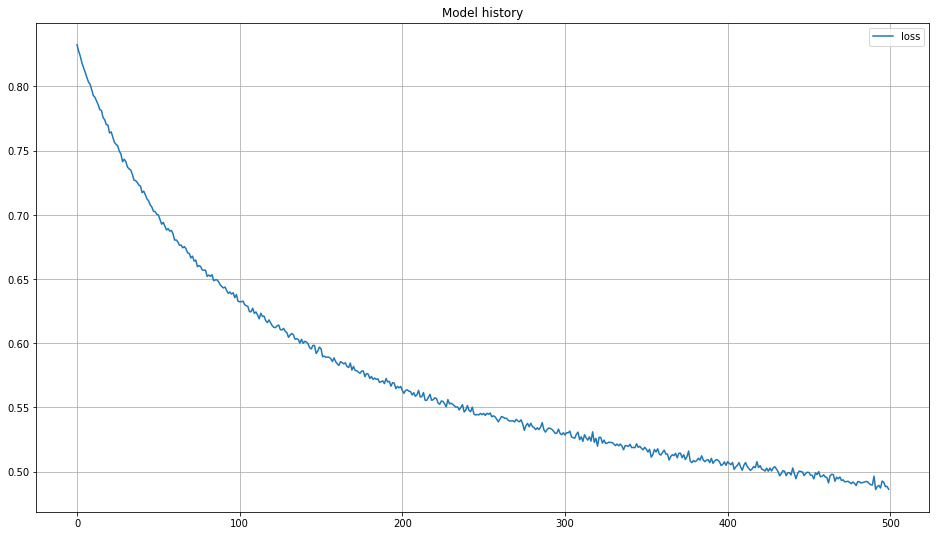

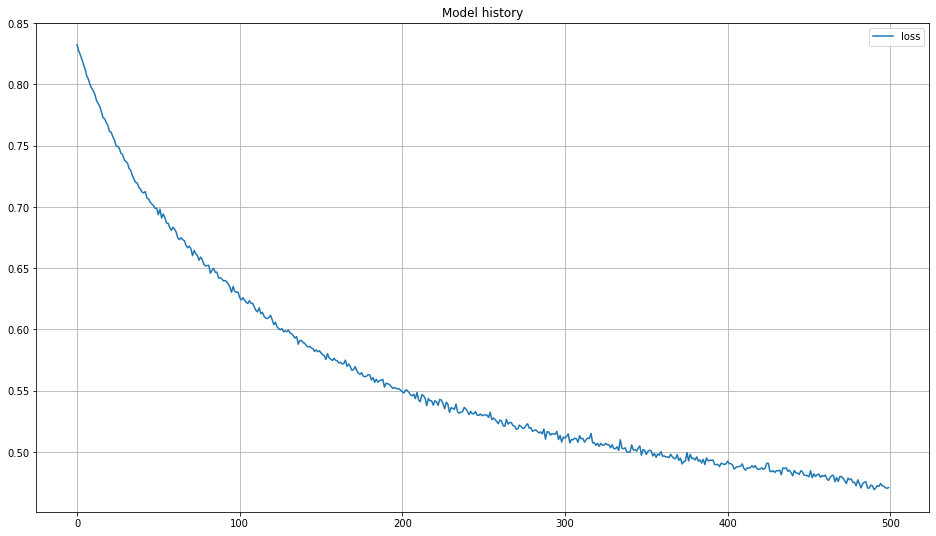

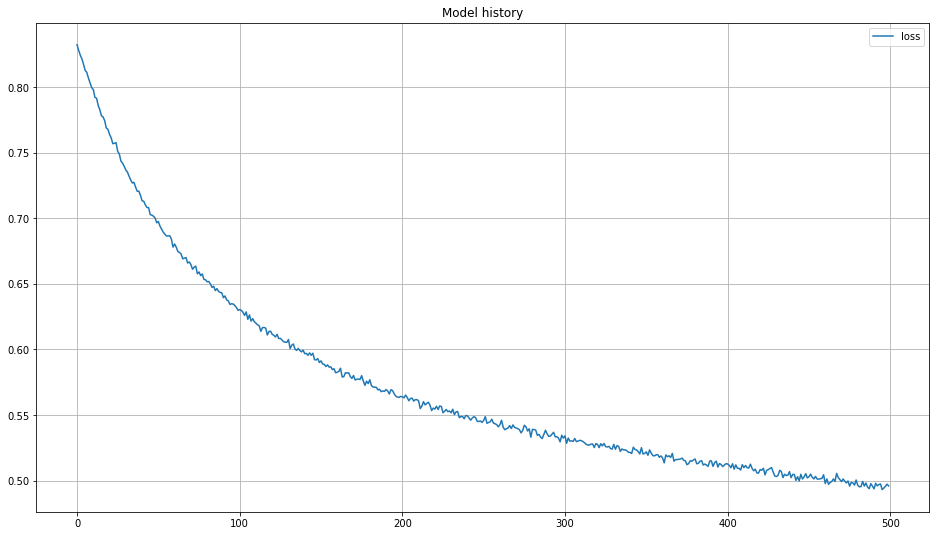

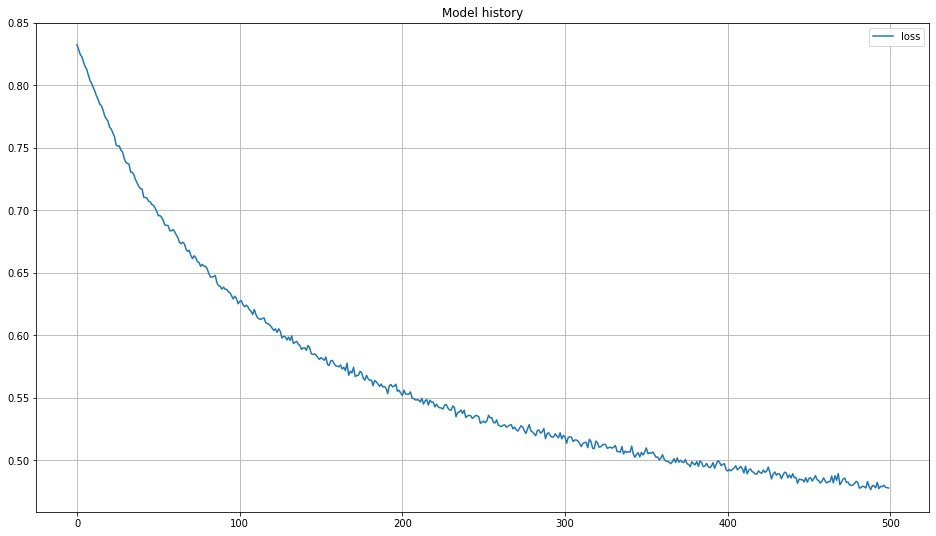

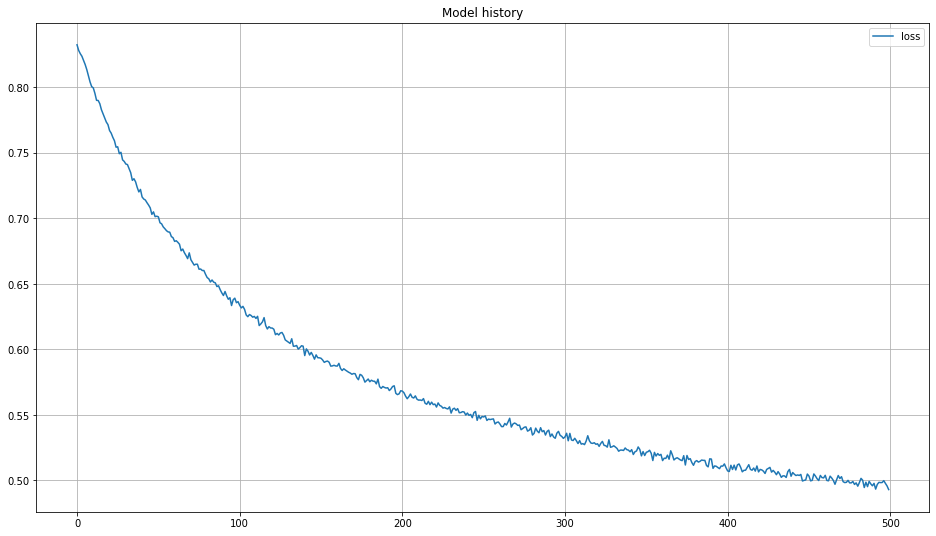

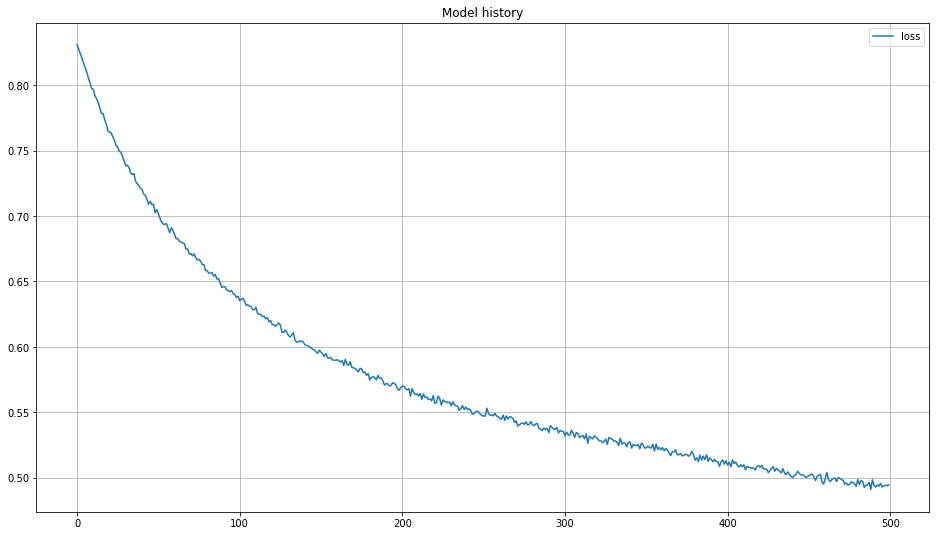

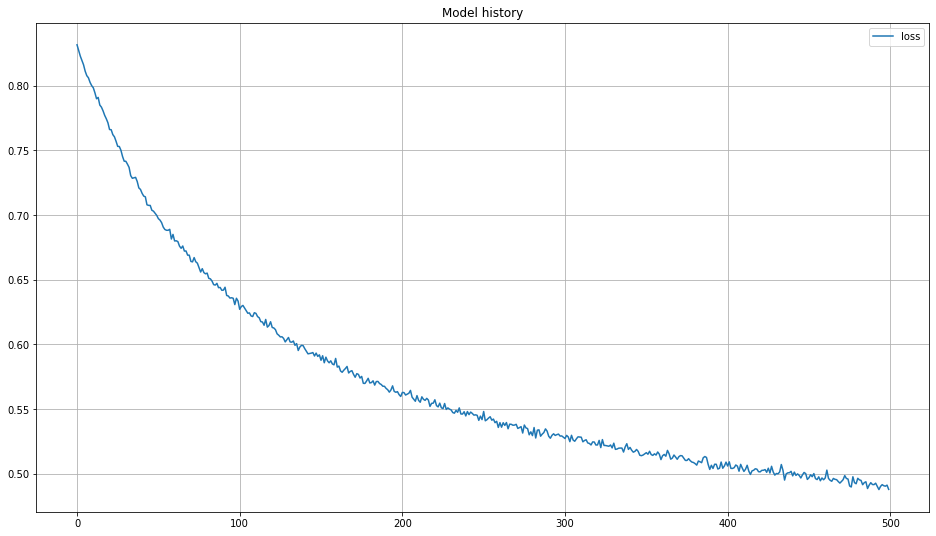

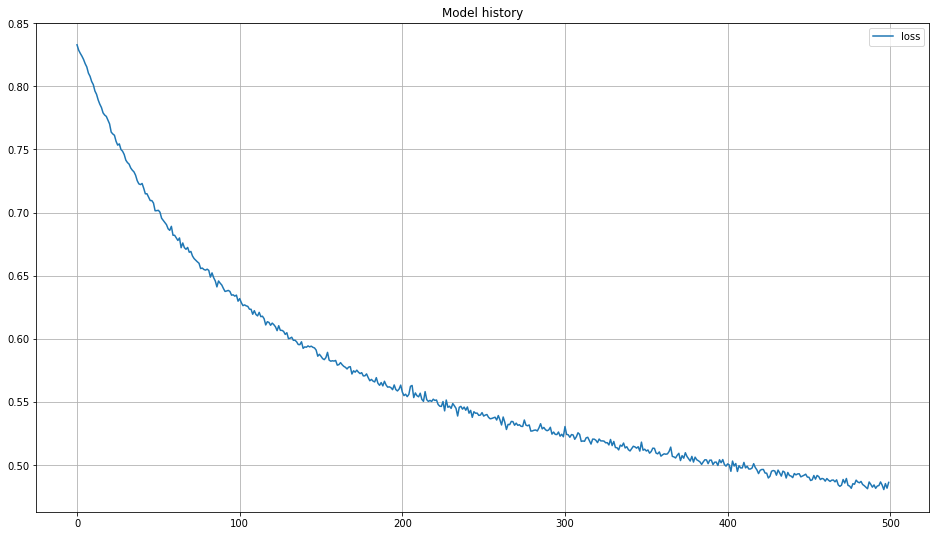

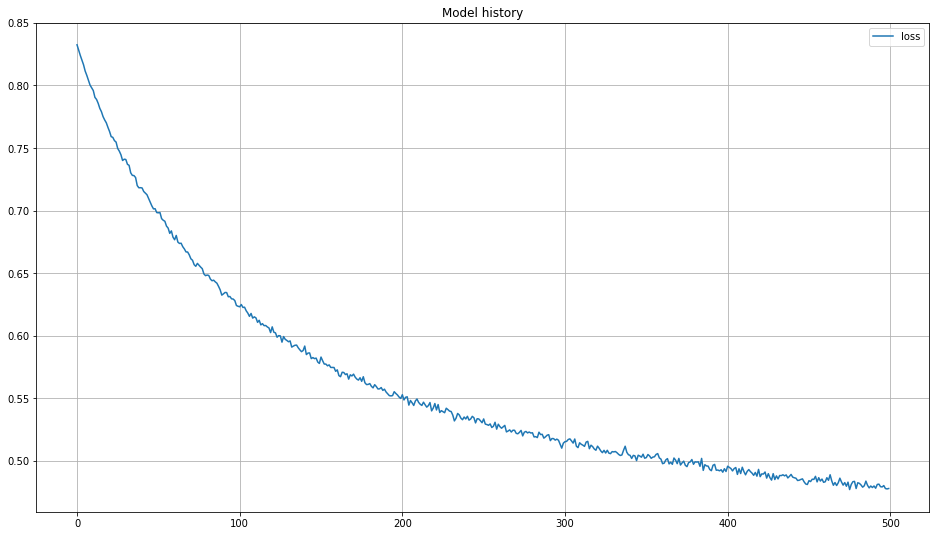

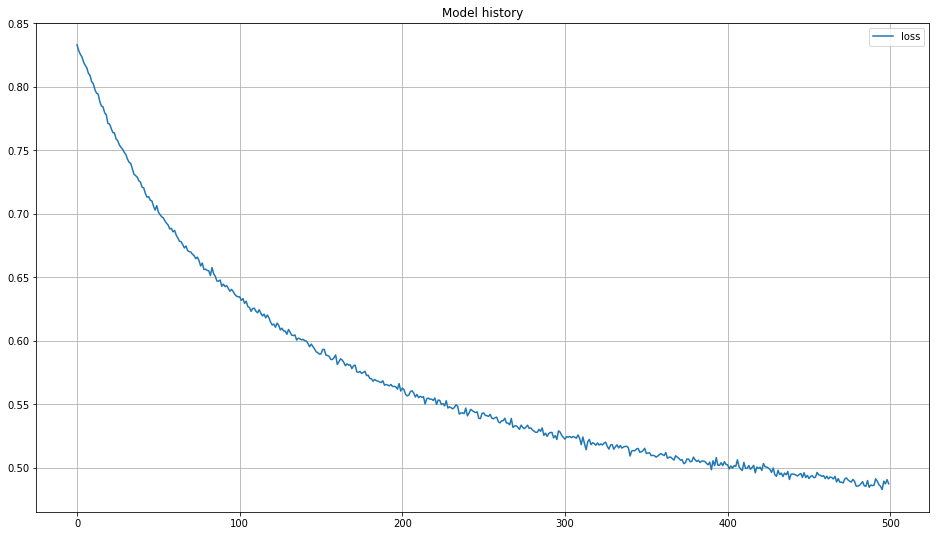

In [23]:
from sklearn.metrics import classification_report, balanced_accuracy_score, roc_auc_score
from sklearn.metrics import normalized_mutual_info_score, mutual_info_score, adjusted_mutual_info_score
NUM_RUNS = 10

ACC = np.zeros(NUM_RUNS)
AUC = np.zeros(NUM_RUNS)
MI = np.zeros(NUM_RUNS)
NMI = np.zeros(NUM_RUNS)
AMI = np.zeros(NUM_RUNS)
BACC = np.zeros(NUM_RUNS)
N_EPOCHS = 500
#N_ANNOT = 59
K= N_CLASSES
AUC= np.zeros(NUM_RUNS)
res = np.zeros(NUM_RUNS)
BATCH_SIZE = 64


for i in range(NUM_RUNS):
   

    model = build_base_model()

    # add crowds layer on top of the base model
    model.add(CrowdsClassification(N_CLASSES, N_ANNOT, conn_type="MW"))


    # instantiate specialized masked loss to handle missing answers
    loss = MaskedMultiCrossEntropy().loss

    # compile model with masked loss and train
    model.compile(optimizer='adam', loss=loss)
    trainHistory =  model.fit(X_train, answers_bin_missings, epochs=N_EPOCHS, shuffle=True, batch_size=BATCH_SIZE, verbose=0)

    # Create the history figure
    plt.figure(figsize=(16,9))
    for g in  trainHistory.history:
        plt.plot( trainHistory.history[g],label=g)
    plt.title('Model history')
    plt.legend()
    plt.grid()
    
     
    # remove crowds layer before making predictions
    model.pop() 
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
   

#     accuracy_test = eval_model(model, X_test, Y_true_test1)
#     print ("Accuracy: Test: %.3f" % (accuracy_test,) )
    
#     val_acc_metric = keras.metrics.CategoricalAccuracy()
#     for x_batch_val, y_batch_val in val_batches_MA:
#         val_logits = model(x_batch_val, training=False)
#         val_acc_metric.update_state(y_batch_val, val_logits)

#     val_acc = val_acc_metric.result()
#     val_acc_metric.reset_states()
#     val_acc = val_acc.numpy()
#     print("Validation acc: %.4f" % (float(val_acc),))
    #res[i] =  accuracy_test 
    
    #AUC =======================
    val_AUC_metric = tf.keras.metrics.AUC( from_logits = True)
    val_logits = model(X_test, training=False)
    # tf.print(y_batch_val)
    val_AUC_metric.update_state(Y_true_test1, val_logits[:,:N_CLASSES].numpy().argmax(axis=1).astype('float'))

    val_AUC = val_AUC_metric.result()
    val_AUC_metric.reset_states()
    val_AUC = val_AUC.numpy()
    print("Validation AUC: %.4f" % (float(val_AUC),))
    #AUC[i] = val_AUC
    val_AUC1 = roc_auc_score(ook(Y_true_test1),  val_logits[:,:N_CLASSES])
    print("Validation aUc_Sklearn: %.4f" % (float(val_AUC1),))
    AUC[i] = val_AUC1
    #===================================================
    
    report = classification_report(val_logits[:,:N_CLASSES].numpy().argmax(axis=1),Y_true_test1.ravel(),output_dict=True)
    ACC[i] = report['accuracy']
    
    
    print("Validation ACC: %.4f" % (float(ACC[i])))
    # balanced. Accurcy
    BACC[i] = balanced_accuracy_score(Y_true_test1.squeeze(), val_logits[:,:N_CLASSES].numpy().argmax(axis=1).squeeze(), adjusted=True)
    print("Validation Balanced_ACC: %.4f" % (float(BACC[i])))

    #MI
    
    MI[i] = mutual_info_score(Y_true_test1.squeeze(), val_logits[:,:N_CLASSES].numpy().argmax(axis=1).squeeze())
    print("Validation MI: %.4f" % (float(MI[i]),))
    NMI[i] = normalized_mutual_info_score(Y_true_test1.squeeze(), val_logits[:,:N_CLASSES].numpy().argmax(axis=1).squeeze())
    print("Validation Normalized MI: %.4f" % (float(NMI[i]),))
    AMI[i]= adjusted_mutual_info_score(Y_true_test1.squeeze(), val_logits[:,:N_CLASSES].numpy().argmax(axis=1).squeeze())
    print("Validation Adjusted MI: %.4f" % (float(AMI[i]),))




In [24]:
# l1 = 0.00001
# MA = Keras_MA_CrowdL(epochs=100,batch_size=32, R = Y_train.shape[1], K=10, dropout=0.25, learning_rate=0.01,optimizer='Adam', 
#                 l1_param=l1, validation_split=0.3, verbose=0)


# MA.fit(X_train, answers_bin_missings)
# MA.plot_history()
# #output_MA_ = MA.predict(X_test)
# #output_MA_.shape


In [25]:
res

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [26]:
import pickle

# create the dictionary with 6 scalar variables
Metrics = {
    'Accuracy': np.round(ACC.mean(),4)*100,
    'Accuracy_std': np.round(np.std( ACC),4)*100,
    'AUC': np.round( AUC.mean(),4)*100,
    'AUC_std': np.round(np.std( AUC),4)*100,
    'Balanced Accuracy': np.round( BACC.mean(),4)*100,
    'Balanced Accuracy_std':  np.round(np.std(BACC),4)*100,
    'MI': np.round( MI.mean(),4)*100,
    'MI_std': np.round(np.std(MI),4)*100,
    'Normalized MI': np.round( NMI.mean(),4)*100,
    'Normalized MI_std': np.round(np.std(NMI),4)*100,
    'Adjusted MI': np.round( AMI.mean(),4)*100,
    'Adjusted MI_std': np.round(np.std(NMI),4)*100,
}

# save the dictionary to a file using pickle
with open('data.pickle', 'wb') as handle:
    pickle.dump(Metrics, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [27]:
Metrics

{'Accuracy': 57.13,
 'Accuracy_std': 2.8000000000000003,
 'AUC': 88.62,
 'AUC_std': 3.08,
 'Balanced Accuracy': 51.470000000000006,
 'Balanced Accuracy_std': 2.91,
 'MI': 122.82,
 'MI_std': 5.09,
 'Normalized MI': 57.25,
 'Normalized MI_std': 1.5599999999999998,
 'Adjusted MI': 54.790000000000006,
 'Adjusted MI_std': 1.5599999999999998}

In [28]:
output_MA_ = MA.predict(X_test)
output_MA_.shape
 

NameError: name 'MA' is not defined

In [ ]:
pred_2 = MA.predict2(X_test)
pred_2

In [ ]:
from sklearn.metrics import classification_report
pred_2 = MA.predict2(X_test)

print(classification_report( pred_2,Y_true_test.argmax(axis=1).ravel()))


# Gridsearch 

In [ ]:
# import numpy as np 
# from sklearn.model_selection import  StratifiedShuffleSplit
# #from scikeras.wrappers import KerasClassifier
# from sklearn.base import BaseEstimator, TransformerMixin
# from sklearn.metrics import make_scorer
# import joblib
# from sklearn.pipeline import Pipeline
# from sklearn.metrics import accuracy_score


# #https://www.adriangb.com/scikeras/stable/notebooks/DataTransformers.html?highlight=data+processing#3.2-Define-output-data-transformer
  
# filename = '/kaggle/working/' + database +'_Rodrigues_models'
# filename_labels = '/kaggle/working/' + database +'_Rodrigues_labels'

# best_parameter = []
# cvresults = []
# classification_report_r= []
# models = []
# labels_pred2=[]
# labels_Y_true=[]

# NUM_RUNS = 10


# for i in range(NUM_RUNS): #10
   
#     print("iteration: " + str(i))
#     Ns = 1
# #     ss =  ShuffleSplit(n_splits=Ns,test_size=0.3, random_state =123)
# #     for train_index, test_index in ss.split(X):
# #        # print(test_index)
# #         X_train, X_test,Y_train,Y_test = X[train_index,:], X[test_index,:],Y[train_index,:], Y[test_index,:]
# #         Y_true_train, Y_true_test = t[train_index].reshape(-1,1), t[test_index].reshape(-1,1)
# #     #print(X_train.shape, Y_train.shape, Y_true_train.shape)
#     MA = Keras_MA_CrowdL(validation_split= 0.3, R= Y_train.shape[1], K= len(np.unique(Y_true_test)))
     
#     #================================ GridSearch =============================================
#     my_func = make_scorer(lambda y,y_pred: MA.custom_CLR_loss(y,y_pred).numpy(),greater_is_better=False)
#     #================== pipeline ===================================== 
#         #se crean listas de steps (pipelines)
#     steps=[('nor', MinMaxScaler()),
#             ('cla', Keras_MA_CrowdL(validation_split= 0.3, R= Y_train.shape[1], K=len(np.unique(Y_true_test)), verbose=0))] #Pipeline1
        
    
  
#     parameters = [{              
#                    'cla__dropout': [0.2,0.25, 0.5, 0.75],#Pipeline1 - hyperparametros
#                  'cla__learning_rate': [ 1e-4,1e-3, 1e-2, 1e-1],
#                   'cla__l1_param': [1e-4, 1e-3, 1e-2, 1e-1],
#                   'cla__batch_size': [32, 64, 128, 256], 
#                   }]

#     label_models = ['model']
    
    
  
     
#     grid = RandomizedSearchCV( Pipeline(steps), parameters,  n_jobs=2, cv=ss, scoring= my_func,
#                         error_score="raise",refit= True,verbose=0, n_iter=15)
    
#    # Y_train_one_hot_targets = tf.one_hot(tf.cast(Y_train , tf.int32), len(np.unique(Y_true_test)), axis = 1, dtype=tf.int32)
#     grid_result = grid.fit(X_train, Y_train)
#     best_parameter += [grid_result.best_params_ ]   
#     cvresults += [grid_result.cv_results_]

#     #estimar etiquetas modelo rodiguez 
#     preds_test_num = grid.best_estimator_[1].predict2(grid.best_estimator_[0].transform(X_test))
#     print(classification_report(Y_true_test,preds_test_num ))

#     labels_pred2 += [preds_test_num]
#     labels_Y_true +=[Y_true_test.ravel()]
 
#     classification_report_r += [classification_report(preds_test_num,Y_true_test.ravel(), output_dict=True)]
     
# joblib.dump([best_parameter,cvresults,classification_report_r],filename+".pkl")
# joblib.dump([labels_pred2,labels_Y_true],filename_labels +".pkl")

In [ ]:
best_parameter

# Computing precision, recall, f1-score  mean values for every class

In [ ]:
  
# val_acc_CrowdL= np.zeros(NUM_RUNS)
# val_Precision =  np.zeros((len(classification_report_r),len(classification_report_r[0].keys())-3))
# val_recall =  np.zeros((len(classification_report_r),len(classification_report_r[0].keys())-3))
# val_f1_score =  np.zeros((len(classification_report_r),len(classification_report_r[0].keys())-3))
# for i in range(len(classification_report_r)):
    
#     for j in range(len(classification_report_r[0].keys())-3):
#         val_Precision[i][j] = classification_report_r[i][str(j)]['precision']
#         val_recall[i][j] = classification_report_r[i][str(j)]['recall']
#         val_f1_score[i][j] = classification_report_r[i][str(j)]['f1-score']
        
     
#     val_acc_CrowdL[i] = classification_report_r[i]['accuracy']
# #print(classification_report_r[0]['precision'])'recall'
# print('Average precision classes: ',  np.mean(val_Precision, axis=0))
# print('Average Recall classes: ', np.mean(val_recall, axis=0))
# print('Average f1_score classes: ', np.mean(val_f1_score, axis=0)) 

In [ ]:
val_acc_CrowdL

In [ ]:
 
print('Average Accuracy: ', np.round(np.mean(val_acc_CrowdL),4)*100) 
print('Average std: ',np.round(np.std(val_acc_CrowdL),4)*100)

In [ ]:
best_batch_list = []
best_dropout_list = []
best_l1_coef_list = []
best_l1_coef_list = []
best_learning_rate_list = []
for i in range(len(best_parameter)):
    best_batch_list += [best_parameter[i]['cla__batch_size']]
    best_dropout_list += [best_parameter[i]['cla__dropout']]
    best_l1_coef_list += [best_parameter[i]['cla__l1_param']]
    best_learning_rate_list += [best_parameter[i]['cla__learning_rate']]
   # print(best_parameter[i]['cla__batch_size'])

 

# Mode  across gridsearch N iteratios parameters

In [ ]:
import numpy as np
from scipy import stats
  

batch_size_mode = np.take(stats.mode(best_batch_list)[0],0)
dropout_mode =  np.take(stats.mode(best_dropout_list ) [0],0)
l1_coef_mode =   np.take(stats.mode(best_l1_coef_list )[0],0)
learning_rate_mode =  np.take(stats.mode(best_learning_rate_list )[0],0)
print('batch_size_mode :',batch_size_mode)
print('dropout_mode :',dropout_mode )
print('l1_coef_mode :', l1_coef_mode)
print('learning_rate_mode: ',learning_rate_mode)

In [ ]:
# scaler = MinMaxScaler()
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)